In [1]:
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.Neural_Network_Module import Dataset, transformations, FeedforwardNeuralNetModel, train_nn
from ipynb.fs.defs.Model_Validation_Module import validation_plots, metrics, eucleidian
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# set the only_env as True if you want to use only environmental features
only_env = True
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'mosquito_regression'
# set the transform argument as True if you want to limit the target variable to 0-9 scale
transform_target = False
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']

In [3]:
data = read_data('../Datasets/Greece/GRE_culex_2011_2023.csv')
#=====================================================================
data = data[data.nuts2_name == 'CENTRAL MACEDONIA']
data = data.reset_index(drop=True)
#=====================================================================
columns = ['x', 'y', 'dt_placement',
           'culex spp.', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean' ]
names = ['x', 'y', 'dt_placement',
         'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/greece_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/greece_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['trap_id', 'station_id', 'x', 'y', 'dt_placement', 'week', 'month',
       'year', 'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code',
       'nuts1_name', 'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex spp.',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_m

In [4]:
data = feature_expansion(data, env=only_env)

In [5]:
data = initializer(data, model_type, dropna=True)

In [6]:
test = data.sample(frac = 0.20, random_state=0)
train = data.drop(data.index[list(test.index)]).reset_index(drop=True)
test = test.reset_index(drop=True)

In [7]:
#define a nn 
model = FeedforwardNeuralNetModel(num_features=len(train.iloc[0,:])-2, num_class=1, encode_layers = [512,360,256,128,64],
                                  decode_layers = [64,128,256,360,512], latent_dim=2, dropout=[0.3,0.3,0,0,0],
                                  model_type=model_type, learning_rate = 0.001, epochs = 100, batch_size = 128,
                                  transformation_list = transformation_list, early_stop = None)

In [8]:
#preprocess nn input
del train[date_col]
date = test[date_col]
del test[date_col]

train_X, train_y, test_X, test_y = transformations(train, test = test, model_type = model.model_type, 
                                                   embedding_data = model.embedding_data,
                                                   transformation_list = model.transformation_list)

training_set = Dataset(train_X, train_y)

testing_set = Dataset(test_X, test_y)

Epoch 001: | Train Loss: 159763.87908 | Val Loss: 306739.79567 | Train Acc: 234.149| Val Acc: 258.889
Epoch 002: | Train Loss: 158848.75381 | Val Loss: 304205.05769 | Train Acc: 233.299| Val Acc: 256.964
Epoch 003: | Train Loss: 157382.59932 | Val Loss: 303349.15264 | Train Acc: 232.240| Val Acc: 256.485
Epoch 004: | Train Loss: 156056.41462 | Val Loss: 302199.84375 | Train Acc: 230.913| Val Acc: 255.893
Epoch 005: | Train Loss: 154559.32420 | Val Loss: 300860.33053 | Train Acc: 229.447| Val Acc: 254.968
Epoch 006: | Train Loss: 152667.74094 | Val Loss: 296150.91947 | Train Acc: 227.985| Val Acc: 251.161
Epoch 007: | Train Loss: 150824.20154 | Val Loss: 295121.12981 | Train Acc: 226.322| Val Acc: 251.150
Epoch 008: | Train Loss: 148505.41609 | Val Loss: 291679.02404 | Train Acc: 224.469| Val Acc: 248.733
Epoch 009: | Train Loss: 146074.71029 | Val Loss: 289964.90264 | Train Acc: 222.084| Val Acc: 247.687
Epoch 010: | Train Loss: 143565.23074 | Val Loss: 285294.82752 | Train Acc: 219.71

Epoch 082: | Train Loss: 21635.97490 | Val Loss: 156405.44141 | Train Acc: 96.967| Val Acc: 183.549
Epoch 083: | Train Loss: 21813.99246 | Val Loss: 154767.34675 | Train Acc: 96.973| Val Acc: 186.410
Epoch 084: | Train Loss: 20878.87577 | Val Loss: 158249.73438 | Train Acc: 95.560| Val Acc: 187.335
Epoch 085: | Train Loss: 21296.57799 | Val Loss: 155026.45913 | Train Acc: 96.597| Val Acc: 184.347
Epoch 086: | Train Loss: 20698.19104 | Val Loss: 154956.83023 | Train Acc: 95.433| Val Acc: 187.250
Epoch 087: | Train Loss: 20128.67950 | Val Loss: 162077.16526 | Train Acc: 94.455| Val Acc: 188.927
Epoch 088: | Train Loss: 20580.80415 | Val Loss: 153455.17578 | Train Acc: 95.364| Val Acc: 185.463
Epoch 089: | Train Loss: 20017.70196 | Val Loss: 156411.87139 | Train Acc: 94.437| Val Acc: 186.788
Epoch 090: | Train Loss: 19974.95002 | Val Loss: 156862.86629 | Train Acc: 94.090| Val Acc: 183.918
Epoch 091: | Train Loss: 19173.88538 | Val Loss: 158684.85457 | Train Acc: 92.649| Val Acc: 186.954


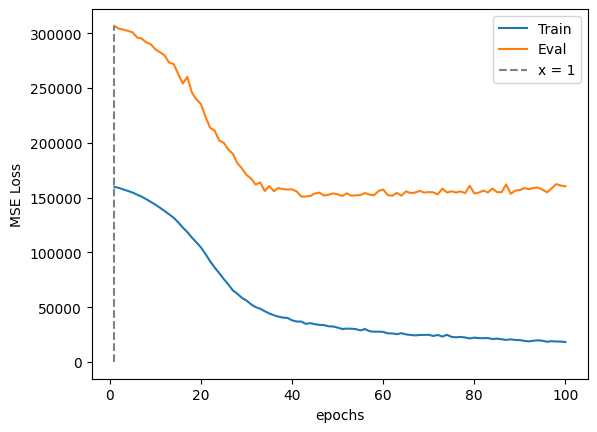

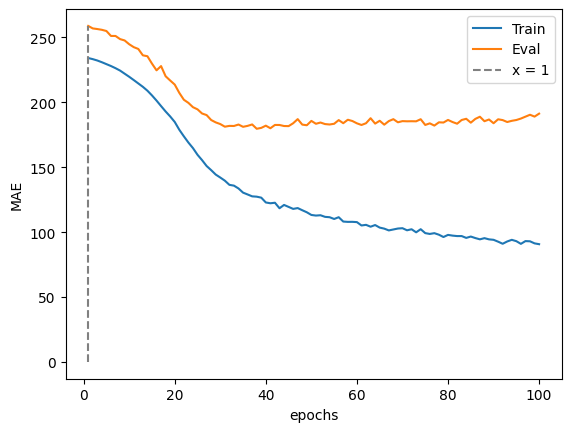

In [9]:
#train_nn
results_train, results_test, latent_train, latent_test, _ = train_nn(model = model, train_set = training_set,
                                                                     test_set = testing_set, features=None, max_val = train_y.max())

MAE on train set:  93.33603870766349
min prediction: 8
max prediction: 1151

MAE on test set:  192.81273408239701
Error <= 30: 17.60 %
min prediction: 12
max prediction: 1100


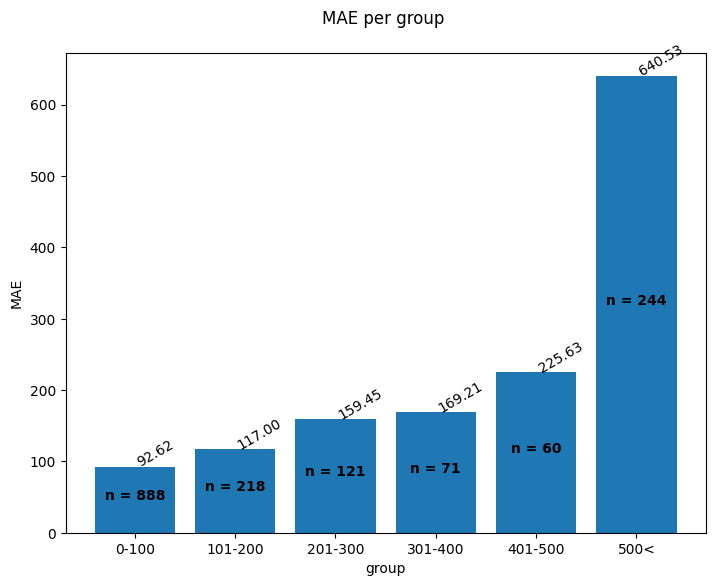

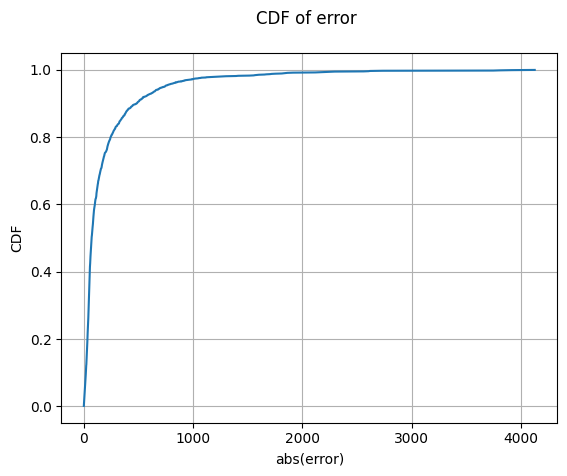

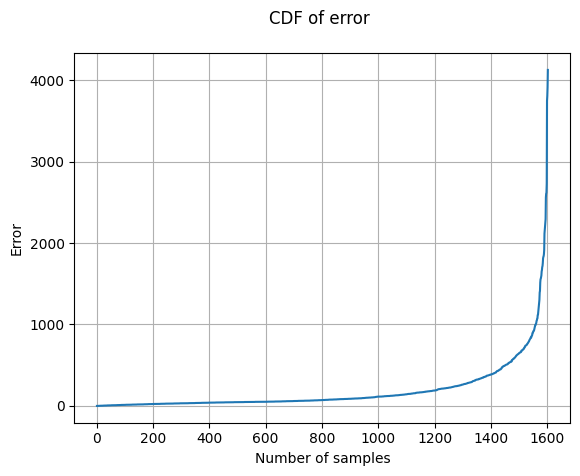

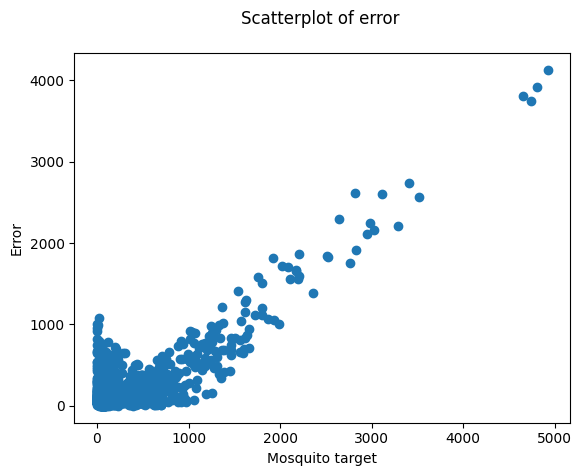

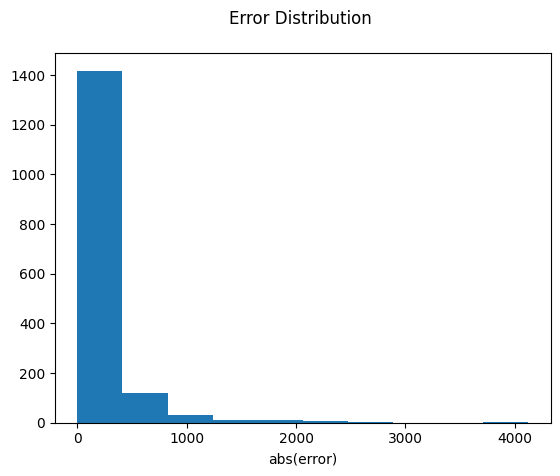

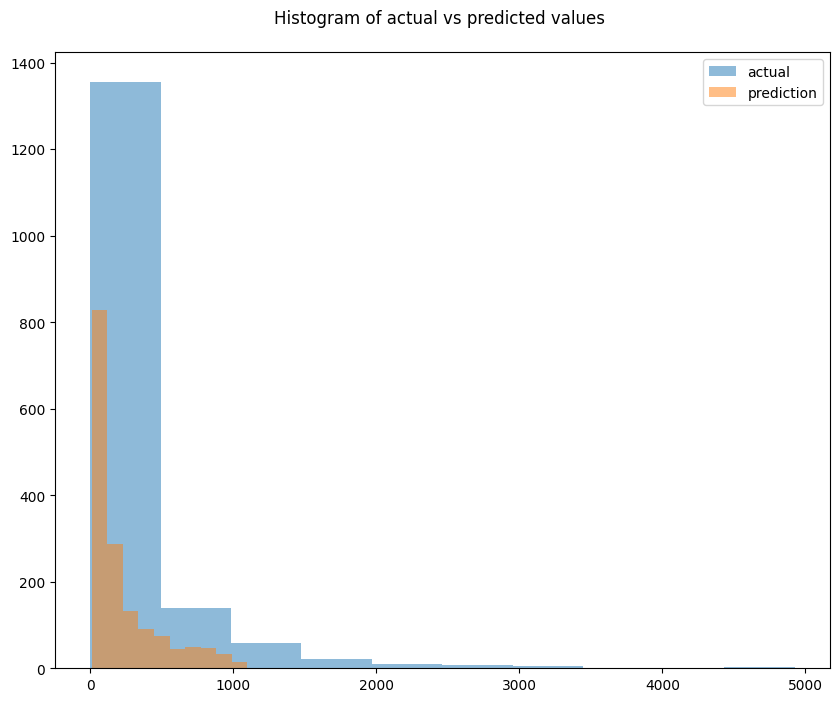

In [10]:
results_test[date_col] = date
results_test['dt_prediction'] = results_test[date_col] + datetime.timedelta(days=15)
results_test['error'] = results_test['actual'] - results_test['prediction']
results_test['abs(error)'] = np.abs(results_test['actual'] - results_test['prediction'])

if model_type == 'mosquito_regression':
    metrics(results_train, results_test, threshold=30)
else:
    metrics(results_train, results_test)
validation_plots(results_test,model_type)

In [11]:
results_train['error'] = results_train['actual'] - results_train['prediction']
results_train['abs(error)'] = np.abs(results_train['actual'] - results_train['prediction'])
results_train = pd.concat([results_train, pd.DataFrame(latent_train)],axis=1)
results_train

,actual,prediction,error,abs(error),0,1
0,80.0,179,-99.0,99.0,-0.152619,4.049188
1,1195.0,726,469.0,469.0,-2.285496,1.723992
2,489.0,731,-242.0,242.0,-0.942692,1.704368
3,82.0,132,-50.0,50.0,-1.542448,4.546325
4,10.0,52,-42.0,42.0,4.263954,5.145783
...,...,...,...,...,...,...
6402,6.0,152,-146.0,146.0,-1.048295,4.317339
6403,63.0,56,7.0,7.0,3.435676,5.133584
6404,260.0,141,119.0,119.0,0.688091,4.099913
6405,118.0,111,7.0,7.0,0.641376,4.574712


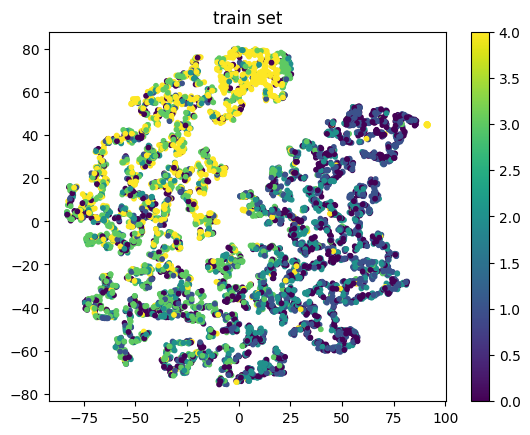

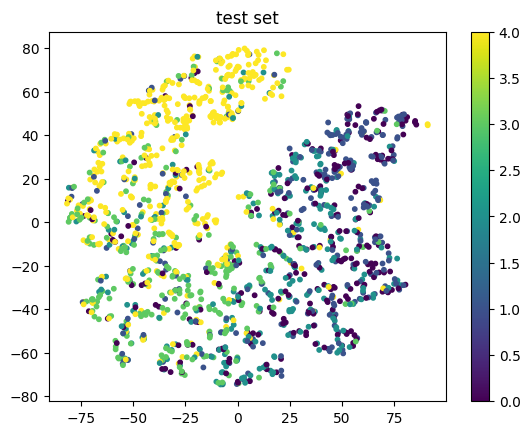

In [12]:
q=5
bins, bounds = pd.qcut(pd.concat([results_train['abs(error)'],results_test['abs(error)']]), retbins=True, q=q, duplicates='drop')

# q=[-1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600]
# bins, bounds = pd.cut(pd.concat([results_train['abs(error)'],results_test['abs(error)']]), bins=q, retbins=True, labels=classes)

bins = bins.cat.codes
latent = np.concatenate((latent_train, latent_test))
colour_dots = pd.concat([results_train['abs(error)'], results_test['abs(error)']])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(latent)
X1_tsne = X_tsne[:latent_train.shape[0],:]
X2_tsne = X_tsne[latent_train.shape[0]:,:]

# Visualize the t-SNE result
plt.scatter(X1_tsne[:, 0], X1_tsne[:, 1], c=bins[:latent_train.shape[0]], s=10)
plt.colorbar()
plt.title('train set')
plt.show()

plt.scatter(X2_tsne[:, 0], X2_tsne[:, 1], c=bins[latent_train.shape[0]:], s=10)
plt.colorbar()
plt.title('test set')
plt.show()

In [13]:
#keep only train observations with error less than MAE
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean(), 0:].reset_index(drop=True)
results_good

,0,1
0,-1.542448,4.546325
1,4.263954,5.145783
2,-1.004018,4.306602
3,-1.831806,1.785695
4,2.380822,3.996951
...,...,...
4308,6.092722,2.788730
4309,3.483425,1.789206
4310,3.435676,5.133584
4311,0.641376,4.574712


In [14]:
percentage = 0.2

In [15]:
euc_M_dist = eucleidian(np.array(results_good), latent_test, 3)
results_test['dist'] = euc_M_dist
results_test_latent = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_latent.corr().loc['abs(error)','dist'])
print("good:", results_test_latent.iloc[:round(len(results_test_latent)*percentage)]['abs(error)'].mean())
print("bad:", results_test_latent.iloc[-round(len(results_test_latent)*percentage):]['abs(error)'].mean())

correlation: 0.030349152368169336
good: 181.128125
bad: 212.359375


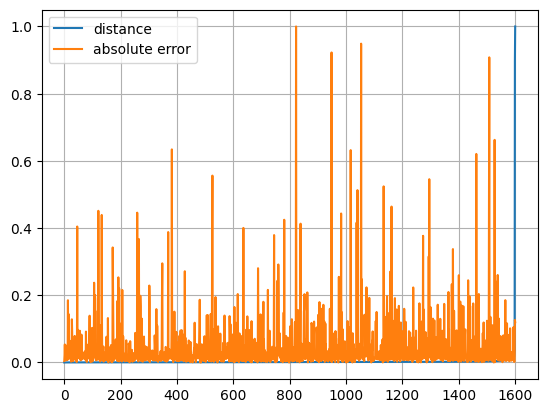

In [16]:
distance = (results_test_latent['dist'] - results_test_latent['dist'].min())/(results_test_latent['dist'].max()-results_test_latent['dist'].min())
error=(results_test_latent['abs(error)']-results_test_latent['abs(error)'].min())/(results_test_latent['abs(error)'].max()-results_test_latent['abs(error)'].min())
plt.plot(distance, label='distance')
plt.plot(error, label='absolute error')
plt.legend()
plt.grid()
plt.show()

In [17]:
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean()].index
results_good = train_X[0][results_good,:]

euc_M_dist = eucleidian(results_good, test_X[0], 3)
results_test['dist'] = euc_M_dist
results_test.corr()
results_test_fs = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_fs.corr().loc['abs(error)','dist'])
print("good:", results_test_fs.iloc[:round(len(results_test_fs)*percentage)][ 'abs(error)'].mean())
print("bad:", results_test_fs.iloc[-round(len(results_test_fs)*percentage):]['abs(error)'].mean())

correlation: 0.03207413135299953
good: 150.13125
bad: 178.840625


In [18]:
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean()].index
results_good = train.loc[results_good,['x','y']]

euc_M_dist = eucleidian(np.array(results_good.drop_duplicates().reset_index(drop=True)), np.array(test[['x','y']]), 3)
results_test['dist'] = euc_M_dist
results_test.corr()
results_test_coord = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_coord.corr().loc['abs(error)','dist'])
print("good:", results_test_coord.iloc[:round(len(results_test_coord)*percentage)]['abs(error)'].mean())
print("bad:", results_test_coord.iloc[-round(len(results_test_coord)*percentage):]['abs(error)'].mean())

correlation: -0.08789838891937062
good: 180.14375
bad: 120.64375
